In [4]:
import os
import wfdb
import pickle
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import load_model
import seaborn as sns
from utils import drop_repeat,cal_cross_validated,generate_marker,BlurPooling1D
np.set_printoptions(suppress=True)
from keras.utils import CustomObjectScope
%matplotlib inline

/Users/hu/.pyenv/versions/3.6.6/envs/Biosignals/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/hu/.pyenv/versions/3.6.6/envs/Biosignals/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [5]:
def plot_scatter(df_crossed,pool_factor,x="accuracy",y="consis_b"):
    plt.title(str(pool_factor) + " Layer CNN",fontsize=20)
    for row in df_crossed[df_crossed.pool_factor==pool_factor].iterrows():
        marker = row[1]["marker"]
        label = row[1]["pool_type"]
        _x = row[1][x]
        _y = row[1][y]
        pool_factor = row[1]["pool_factor"]
        if pool_factor == 1:
            edge_color = "b"
        elif pool_factor == 2:
            edge_color = "r"
        elif pool_factor == 3:
            edge_color = "purple"
        c = 'w'
        if marker == "|":
            c = edge_color
        plt.scatter(x=_x,y=_y,marker=marker,c=c,edgecolors=edge_color,s=100,label=label)

In [6]:
def cal_blur_size(pool_type):
    if "maxblur" in pool_type:
        return int(pool_type[-1])
    if pool_type=="max":
        return 0
    if pool_type=="avg":
        return -1

## Read result dataframe (CNN)

In [7]:
result_roots = ["./Result_CNN_pool1/","./Result_CNN_pool2/","./Result_CNN_pool3/"]

In [8]:
result_files = []
for result_root in result_roots:
    result_dirs = [os.path.join(result_root,i) for i in os.listdir(result_root) if "results" in i]
    for result_dir in result_dirs:
        result_file = os.path.join(result_dir,"new_result.csv")
        if os.path.exists(result_file):
            result_files.append(result_file)
result_files.sort()

In [9]:
dfs = []
for file in result_files:
    df = pd.read_csv(file)
    df = df.drop(['_'],axis=1)
    pool_type = list(df["pool_type"])[0]
    if pool_type == "maxblur-":
        df["pool_type"] = ["avg" for i in range(len(df))]
        pool_type = "avg"
    df["marker"] = [generate_marker(pool_type) for i in range(len(df))]
    df["blur_size"] = [cal_blur_size(pool_type) for i in range(len(df))]
    dfs.append(df)
result_df = pd.concat(dfs)

In [10]:
result_df.head()

,idx,pool_factor,pool_type,cross_idx,repeat_idx,loss,accuracy,consis_b,consis_ub,consis_n,consis_a,consis_a_s,marker,blur_size
0,2,1,max,0,1,1.267224,0.831081,0.797629,0.772520,0.772447,0.772534,0.822811,$M$,0
1,14,1,max,1,3,1.258857,0.772727,0.740067,0.845580,0.535488,0.905061,0.944646,$M$,0
2,24,1,max,2,3,0.452523,0.893333,0.861284,0.737744,0.988930,0.690847,0.733638,$M$,0
3,32,1,max,3,1,0.100253,0.952055,0.943946,0.914907,0.979087,0.903252,0.908806,$M$,0
4,42,1,max,4,1,0.490812,0.856164,0.830203,0.701976,0.890881,0.667674,0.769526,$M$,0


In [11]:
result_df.to_csv("final_result.csv",header=True)

In [12]:
result_df_crossed = cal_cross_validated(result_df,cross=5)

In [14]:
result_df_crossed.to_csv("final_result_crossed.csv",header=True)

## Find out how pooling factor influence results

In [15]:
def plot_scatter_factor(df_crossed,pool_type,x="accuracy",y="consis_b"):
    for row in df_crossed[df_crossed.pool_type==pool_type].iterrows():
        marker = row[1]["marker"]
        pool_factor = row[1]["pool_factor"]
        label = pool_type + str(pool_factor)
        _x = row[1][x]
        _y = row[1][y]
        if pool_factor == 1:
            edge_color = "b"
        elif pool_factor == 2:
            edge_color = "r"
        elif pool_factor == 3:
            edge_color = "purple"
        if pool_type=="avg":
            c="w"
        else:
            c=edge_color
        plt.scatter(x=_x,y=_y,marker="o",c=c,edgecolors=edge_color,s=100,label=label)
    plt.legend()

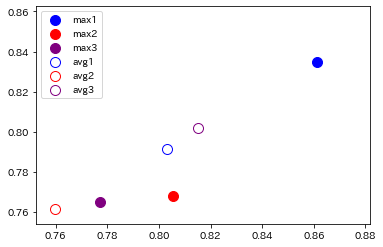

In [16]:
plt.title("",fontsize=20)
plot_scatter_factor(result_df_crossed,pool_type="max",x="accuracy",y="consis_b")
plot_scatter_factor(result_df_crossed,pool_type="avg",x="accuracy",y="consis_b")

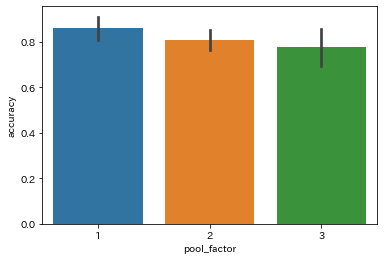

In [17]:
sns.barplot(data=result_df[(result_df.pool_type=="max")],x="pool_factor",y="accuracy")

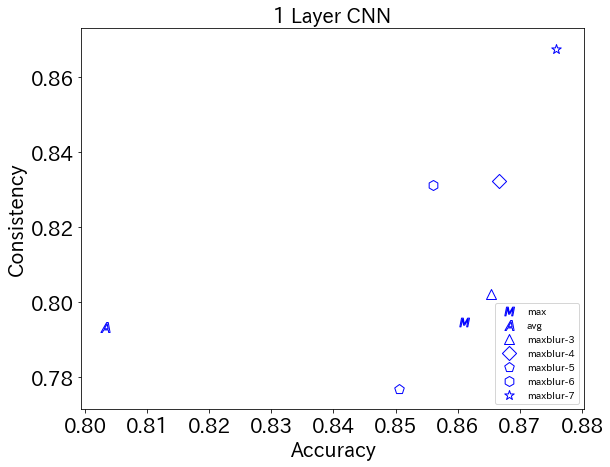

In [18]:
plt.figure(figsize=(9,7))
#plt.plot([0.861072,0.865392],[0.834626,0.857947],c="g")
#plt.plot([0.803283,0.875873],[0.793278,0.867690],c="g")
#plt.plot([0.861072,0.875873],[0.794545,0.867690],c="orange")
plot_scatter(result_df_crossed[(result_df_crossed.pool_type!="maxblur-1")&
                              (result_df_crossed.pool_type!="maxblur-2")],pool_factor=1,x="accuracy",y="consis_ub")
plt.xlabel("Accuracy",fontsize=20)
plt.ylabel("Consistency",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right")

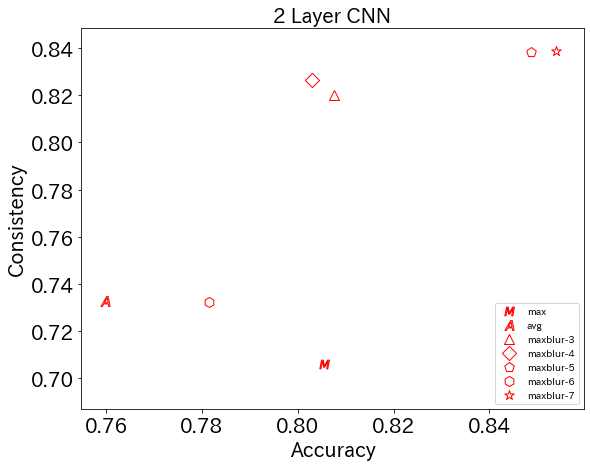

In [19]:
plt.figure(figsize=(9,7))
#plt.plot([0.861072,0.865392],[0.834626,0.857947],c="g")
#plt.plot([0.803283,0.875873],[0.793278,0.867690],c="g")
#plt.plot([0.861072,0.875873],[0.794545,0.867690],c="orange")
plot_scatter(result_df_crossed[(result_df_crossed.pool_type!="maxblur-1")&
                              (result_df_crossed.pool_type!="maxblur-2")],pool_factor=2,x="accuracy",y="consis_ub")
plt.xlabel("Accuracy",fontsize=20)
plt.ylabel("Consistency",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right")

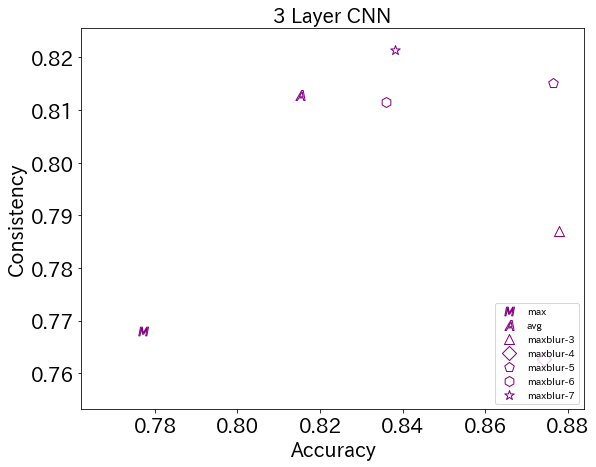

In [20]:
plt.figure(figsize=(9,7))
#plt.plot([0.861072,0.865392],[0.834626,0.857947],c="g")
#plt.plot([0.803283,0.875873],[0.793278,0.867690],c="g")
#plt.plot([0.861072,0.875873],[0.794545,0.867690],c="orange")
plot_scatter(result_df_crossed[(result_df_crossed.pool_type!="maxblur-1")&
                              (result_df_crossed.pool_type!="maxblur-2")],pool_factor=3,x="accuracy",y="consis_ub")
plt.xlabel("Accuracy",fontsize=20)
plt.ylabel("Consistency",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right")

## Compare consistency

In [21]:
def compare_consistency(result_df,pool_type):
    plt.subplot(131)
    sns.barplot(data=result_df[result_df.pool_type==pool_type],x="pool_type",y="consis_a",capsize=0.15
               ,linewidth=2.5, facecolor="w",errcolor=".2", edgecolor="g")
    plt.ylim(0,1)
    plt.xticks([])
    plt.ylabel("Consistency",fontsize=15)
    plt.xlabel("AF",fontsize=15)

    plt.subplot(132)
    plt.title(pool_type,fontsize=15)
    sns.barplot(data=result_df[result_df.pool_type==pool_type],x="pool_type",y="consis_b",capsize=0.15,color="g")
    plt.ylim(0,1)
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("")
    
    plt.xlabel("Total",fontsize=15)

    plt.subplot(133)
    sns.barplot(data=result_df[result_df.pool_type==pool_type],x="pool_type",y="consis_n",capsize=0.15
               ,linewidth=2.5, facecolor="w",
                errcolor=".2", edgecolor="g")
    plt.ylim(0,1)
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("")
    plt.xlabel("Normal",fontsize=15)
    plt.show()

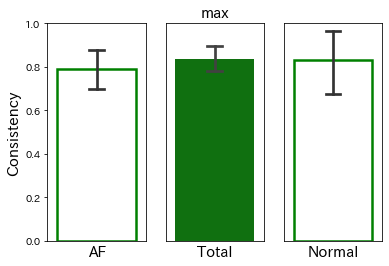

In [22]:
compare_consistency(result_df[result_df.pool_factor==1],pool_type="max")

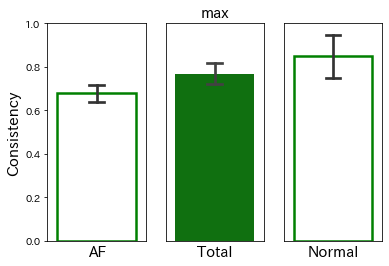

In [23]:
compare_consistency(result_df[result_df.pool_factor==2],pool_type="max")

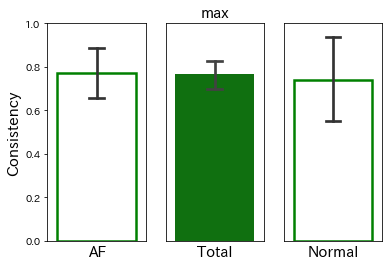

In [24]:
compare_consistency(result_df[result_df.pool_factor==3],pool_type="max")

## Plot Blur Filter

In [25]:
def Get_BlurFilter(filt_size):
    if(filt_size==1):
        return np.array([1.,])
    elif(filt_size==2):
        return np.array([1., 1.])
    elif(filt_size==3):
        return np.array([1., 2., 1.])
    elif(filt_size==4):    
        return np.array([1., 3., 3., 1.])
    elif(filt_size==5):    
        return np.array([1., 4., 6., 4., 1.])
    elif(filt_size==6):    
        return np.array([1., 5., 10., 10., 5., 1.])
    elif(filt_size==7):    
        return np.array([1., 6., 15., 20., 15., 6., 1.])

2
3
4
5
6
7


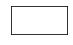

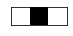

In [26]:
blur_size = 5
for blur_size in [i+2 for i in range(6)]:
    print(blur_size)
    plt.figure(figsize=(1,5))
    _filter = np.expand_dims(Get_BlurFilter(blur_size),axis=0)

    plt.xticks([])
    plt.yticks([])
    plt.imshow(_filter,cmap="Greys")

In [27]:
import matplotlib
plt.figure(figsize=(1,1))
cmap = matplotlib.cm.Greys
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
plt.imshow(np.expand_dims(np.array([.5,.5,.5,.5]),axis=0),cmap=cmap,norm=norm)
#plt.colorbar()
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)